# The Enigma of Task Decomposition in Neural Networks
Framing:
  - Teaching Neural Networks Task Decomposition remains widely unsolved (Subgoal model predicts subgoals with small errors that the Synthesizer model omits, but synth model also knows how to decompose)
  - Sampling is an alternative way to decompose tasks 

In [1]:
import pandas as pd
import json
import numpy as np
import re

import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib.patches as mpatches
from IPython.core.pylabtools import figsize
from matplotlib_inline.backend_inline import set_matplotlib_formats
import tikzplotlib

%matplotlib inline
set_matplotlib_formats('retina') # high-res display in notebook

# Set the Seaborn theme
context = 'paper'  # paper, talk, or notebook

save_settings = {'format': 'svg'}  # always use svg as it allows scaling figures up & down without losing resolution! 

if context == 'talk':
    pal = sns.color_palette('deep')
    PALETTE = {"TIIPS": "#115e17", "ExeDec": "#a2af9f", "Ground truth": "#6e7a6c", 'No-Subgoal Ablation': "#0094c2", 'Baseline': "#00618C", 'Both': "#6e7a6c", 'MLITS Only': "#115e17", "ExeDec Only": "#a2af9f", "No-Subgoal Ablation Only":"#0094c2", 'Both - MLITS': "#115e17", "Both - ExeDec": "#a2af9f", "Both - No-Subgoal Ablation": "#0094c2"}
    sns.set_theme(context='talk', style='whitegrid', palette=sns.color_palette(PALETTE.values()), font_scale=2)
else:
    pal = sns.color_palette('colorblind')
    PALETTE = {"TIIPS": "#115e17", "ExeDec": "#a2af9f", "Ground truth": "#6e7a6c", 'No-Subgoal Ablation': "#0094c2", 'Baseline': "#00618C", 'Both': "#6e7a6c", 'MLITS Only': "#115e17", "ExeDec Only": "#a2af9f", "No-Subgoal Ablation Only":"#0094c2", 'Both - MLITS': "#115e17", "Both - ExeDec": "#a2af9f", "Both - No-Subgoal Ablation": "#0094c2"}
    sns.set_theme(context=context, style='whitegrid', palette=sns.color_palette(PALETTE.values()), font_scale=2)

In [2]:
SEEDS = [10, 20, 30, 40, 50]
SYNTH_MODEL = "synthesizer_model"
EXPERIMENTS = ["NONE", "LENGTH_GENERALIZATION", "COMPOSE_DIFFERENT_CONCEPTS", "SWITCH_CONCEPT_ORDER", "COMPOSE_NEW_OP", "ADD_OP_FUNCTIONALITY"]
EXP_LBL_MAP = {"NONE": 'Test on training distribution', "LENGTH_GENERALIZATION": 'Length generalization', "COMPOSE_DIFFERENT_CONCEPTS": 'Compose different concepts', "SWITCH_CONCEPT_ORDER": 'Switch concept order', "COMPOSE_NEW_OP": 'Compose new operation', "ADD_OP_FUNCTIONALITY": 'Add operation functionality'}
PT_MAPPING = {"separate": "ExeDec", "joint": "No-Subgoal Ablation", "sampling_updates": "Baseline", "ensemble": "Ensemble", 'separate-': 'TIIPS'}
DATASET = {"robustfill": "String manipulation", "deepcoder": "List manipulation"}

HANDLES = [
        mpatches.Patch(color="#115e17", label="TIIPS"),
        mpatches.Patch(color="#115e17", label="Baseline"),
        mpatches.Patch(color="#a2af9f", label="ExeDec"),
    ]

### Method Definition

In [11]:
def get_length(solution):
    subprograms = solution.split(' | ')
    num_subprograms = len(subprograms)
    num_inputs = sum(1 for sub in subprograms if 'INPUT' in sub)
    length = num_subprograms - num_inputs
    return length

def load_decomposition_data(ds, key, subdir='', task_index=True, threshold=1000, step_size=20):
    path = f"./tiips_results/evaluation/{ds}_e2e_predict_1/{subdir}/end_to_end_predict-{ds}-run-e2e_predict_1-"
    results = {"TIIPS": {s: {k: [] * 5 for k in EXPERIMENTS} for s in SEEDS}, "ExeDec": {s: {k: [] * 5 for k in EXPERIMENTS} for s in SEEDS}, "Baseline": {s: {k: [] * 5 for k in EXPERIMENTS} for s in SEEDS}}
    
    for prediction_type in results.keys():
        pt = prediction_type
        for experiment in EXPERIMENTS:
            
            for j, seed in enumerate(SEEDS):
                if pt == "TIIPS":
                    prediction_type = 'separate-'
                elif pt == "Baseline":
                    prediction_type = f'sampling_updates'
                elif pt == "No-Subgoal Ablation":
                    prediction_type = f'joint'
                elif pt == "ExeDec":
                    prediction_type = f'separate'
                else:
                    raise ValueError(f"No such type as {prediction_type}")

                pty = prediction_type[:-1] if prediction_type == 'separate-' else f'{prediction_type}'

                try:
                    with open(path + prediction_type  + f'/tb/hparams-dataset_type={ds},prediction_type={pty},experiment={experiment},beam_size=10,seed={seed}/results-{pty}.json') as f:
                        data = json.load(f)
                except FileNotFoundError:
                    if prediction_type == 'sampling_updates':
                      print(path + prediction_type  + f'/tb/hparams-dataset_type={ds},prediction_type={pty},experiment={experiment},beam_size=10,seed={seed}/results-{pty}.json')
                    continue    
                if len(data) != threshold:
                    continue

                try:
                    for task in data:
                        r = task[key]
                        if task['success'] and get_length(task['solution']) <= 1:
                            r = np.nan
                        if prediction_type == 'separate':
                            if r:
                                if task[key] > get_length(task['solution']) and task['success']:
                                    r = get_length(task['solution'])
                                elif not task['success'] and task[key] > get_length(task['ground_truth']):
                                    r = get_length(task['ground_truth'])
                                
                            results[PT_MAPPING[prediction_type]][seed][experiment].append({"success": task['success'], "subgoal_success": r / get_length(task['solution']) if task['success'] else r / get_length(task['ground_truth']), 'subprogram_success_rate': sum([1 if a == b else 0 for a, b in zip(task['solution'].split(' | '), task['ground_truth'].split(' | '))]) / len(task['solution'].split(' | ')), 'Task': task['test_example_index'] if task_index else task, 'Subgoal Error': task['subgoal_first_error']})
                        else:
                            results[PT_MAPPING[prediction_type]][seed][experiment].append({"success": task['success'], "subgoal_success": task['synth_subgoal_success'] / get_length(task['solution']) if task['success'] else task['synth_subgoal_success'] / get_length(task['ground_truth']), 'subprogram_success_rate': sum([1 if a == b else 0 for a, b in zip(task['solution'].split(' | '), task['ground_truth'].split(' | '))]) / len(task['solution'].split(' | ')), 'Task': task['test_example_index'] if task_index else task, 'Subgoal Error': -1})
                except KeyError:
                    continue
      
    df_list = []
    for pred_type, subdict in results.items():
        for s, subsubdict in subdict.items():
            for exp, values in subsubdict.items():
                for value in values:
                    df_list.append({'Approach': pred_type, 'Success': value["success"], 'Correct Subgoals': value['subgoal_success'] * 100, 'Correct Subprograms': value['subprogram_success_rate'] * 100, 'Experiment': exp, 'Seed': s, 'Task': value['Task'], 'Subgoal First Error': value['Subgoal Error']})
    
    df = pd.DataFrame(df_list)
    return df

import re

def includes_compose(program: str) -> bool:
    return bool(re.search(r'\b\w+\(\s*\w+\s*\([^()]*\)', program))

def load_performance_data(ds, subdir='', threshold=1000, step_size=10):
    accuracies = {"Baseline": [], "ExeDec": {}, "TIIPS": {}}
    num_steps_sp = {"separate": [], "gt": []}
    num_steps_bu = {"baseline": [], "gt": []}
    num_steps_ml = {"tiips": [], "gt": []}
    for prediction_type in ["tiips", "baseline", 'separate']:
        if prediction_type == 'tiips':
            path = f"../tiips_results/evaluation/{ds}_e2e_predict_1/{subdir}/end_to_end_predict-{ds}-run-e2e_predict_1-"
        else: 
            path = f"./tiips_results/evaluation/{ds}_e2e_predict_1/{subdir}/end_to_end_predict-{ds}-run-e2e_predict_1-"
        exp = {k: [np.nan] * 5 for k in EXPERIMENTS}
        for experiment in EXPERIMENTS:
            for j, seed in enumerate(SEEDS): 
                pty = prediction_type[:-1] if prediction_type == 'separate-' else f'{prediction_type}'

                try:
                    with open(path + prediction_type  + f'-/tb/hparams-dataset_type={ds},prediction_type={pty},experiment={experiment},beam_size=10,seed={seed}/results-{pty}.json') as f:
                        data = json.load(f)
                except FileNotFoundError:
                    # print(path + prediction_type + f'/tb/hparams-dataset_type={ds},prediction_type={prediction_type},experiment={experiment},beam_size=10,seed={seed}/results-{prediction_type}.json')
                    continue

                exp[experiment][j] = len([ele for ele in data if ele["success"]]) / len(data) * 100 if len(data) == threshold else np.nan
                
                if prediction_type == "separate": 
                    num_steps_sp[prediction_type] += [get_length(ele["solution"]) for ele in data if ele["success"]]
                    num_steps_sp["gt"] += [ele["ground_truth_length"] for ele in data if ele["success"]]
                elif prediction_type == "baseline": 
                    num_steps_bu[prediction_type] += [get_length(ele["solution"]) for ele in data if ele["success"]]
                    num_steps_bu["gt"] += [ele["ground_truth_length"] for ele in data if ele["success"]]
                elif prediction_type == "tiips": 
                    num_steps_ml[prediction_type] += [get_length(ele["solution"]) for ele in data if ele["success"]]
                    num_steps_ml["gt"] += [ele["ground_truth_length"] for ele in data if ele["success"]]
            if prediction_type == "baseline":
                k = "Baseline"
            elif prediction_type == "separate":
                k = "ExeDec"
            elif prediction_type == "tiips":
                k = "TIIPS"
            else:
                raise ValueError(f"Unknown prediction type: {prediction_type}")
        accuracies[k] = exp
    return accuracies

def load_performance_data_compose(ds, subdir='', threshold=1000, step_size=10, sol_contains_compose=False):
    path = f"./mixed_results/evaluation/{ds}_e2e_predict_1/{subdir}/end_to_end_predict-{ds}-run-e2e_predict_1-"
    accuracies = {"Baseline": [], "ExeDec": {},"No-Subgoal Ablation": {}, "TIIPS": {}}
    num_steps_jt = {"joint": [], "gt": []}
    num_steps_sp = {"separate": [], "gt": []}
    num_steps_bu = {"sampling_updates": [], "gt": []}
    num_steps_ml = {"separate-": [], "gt": []}
    for prediction_type in ["separate", "joint", "sampling_updates", 'separate-']:
        exp = {k: [np.nan] * 5 for k in EXPERIMENTS}
        for experiment in EXPERIMENTS:
            for j, seed in enumerate(SEEDS): 
                pty = prediction_type[:-1] if prediction_type == 'separate-' else f'{prediction_type}'

                try:
                    with open(path + prediction_type  + f'/tb/hparams-dataset_type={ds},prediction_type={pty},experiment={experiment},beam_size=10,seed={seed}/results-{pty}.json') as f:
                        data = json.load(f)
                except FileNotFoundError:
                    # print(path + prediction_type + f'/tb/hparams-dataset_type={ds},prediction_type={prediction_type},experiment={experiment},beam_size=10,seed={seed}/results-{prediction_type}.json')
                    continue
                
                comp_ground_truth, comp_solu, comp_cont_in_sol = [], [], []
                if sol_contains_compose:
                    for ele in data:
                        if includes_compose(ele['ground_truth']):
                            comp_ground_truth.append(ele)
                            if ele['success']:
                                comp_solu.append(ele)
                                if includes_compose(ele['solution']):
                                    comp_cont_in_sol.append(ele)
                    exp[experiment][j] = len(comp_cont_in_sol) / len(comp_ground_truth) * 100 if len(comp_ground_truth) > 0 else np.nan
                else:
                    comp_ground_truth, comp_solu = [], []
                    for ele in data:
                        if not includes_compose(ele['ground_truth']):
                            comp_ground_truth.append(ele)
                            if ele['success']:
                                comp_solu.append(ele)
                                if not includes_compose(ele['solution']):
                                    comp_cont_in_sol.append(ele)
                    exp[experiment][j] = len(comp_cont_in_sol) / len(comp_ground_truth) * 100 if len(comp_ground_truth) > 0 else np.nan

                if prediction_type == "joint": 
                    num_steps_jt[prediction_type] += [get_length(ele["solution"]) for ele in data if ele["success"]]
                    num_steps_jt["gt"] += [ele["ground_truth_length"] for ele in data if ele["success"]]
                elif prediction_type == "separate": 
                    num_steps_sp[prediction_type] += [get_length(ele["solution"]) for ele in data if ele["success"]]
                    num_steps_sp["gt"] += [ele["ground_truth_length"] for ele in data if ele["success"]]
                elif prediction_type == "sampling_updates": 
                    num_steps_bu[prediction_type] += [get_length(ele["solution"]) for ele in data if ele["success"]]
                    num_steps_bu["gt"] += [ele["ground_truth_length"] for ele in data if ele["success"]]
                elif prediction_type == "separate-": 
                    num_steps_ml[prediction_type] += [get_length(ele["solution"]) for ele in data if ele["success"]]
                    num_steps_ml["gt"] += [ele["ground_truth_length"] for ele in data if ele["success"]]
            if prediction_type == "joint":
                k = "No-Subgoal Ablation"
            elif prediction_type == "sampling_updates":
                k = "Baseline"
            elif prediction_type == "ensemble":
                k = "Ensemble"
            elif prediction_type == "separate":
                k = "ExeDec"
            elif prediction_type == "separate-":
                k = "TIIPS"
            elif prediction_type == "baseline":
                k = "Synthesizer Model"
            else:
                raise ValueError(f"Unknown prediction type: {prediction_type}")
        accuracies[k] = exp
    return accuracies


def contains_ood_operation(ground_truth_program, solution_program, ood_operations):
    """
    Checks if the solution program contains any OOD operation from the ground truth program.
    
    Args:
        ground_truth_program (str): The ground truth program as a string.
        solution_program (str): The solution program as a string.
        ood_operations (set): A set of operations considered OOD.
    
    Returns:
        bool: True if the solution program contains the OOD operation from the ground truth program, False otherwise.
    """
    # Extract operations from the ground truth program
    ground_truth_operations = extract_operations(ground_truth_program)
    
    # Extract operations from the solution program
    solution_operations = extract_operations(solution_program)
    
    # Check if the solution program contains any OOD operation from the ground truth
    return any(is_prefix_in_set(op, ood_operations) for op in ground_truth_operations) and \
           any(is_prefix_in_set(op, ood_operations) for op in solution_operations)

def extract_operations(program):
    """
    Extracts operations used in the program by splitting at '|' and removing variables.
    
    Args:
        program (str): The program as a string.
    
    Returns:
        list: A list of cleaned operations found in the program.
    """
    operations = []
    for part in program.split('|'):
        # Remove variable assignments and usages (e.g., 'x0 = ', 'x1', etc.)
        cleaned_part = re.sub(r'\bx\d+\b|=', '', part).strip()
        if cleaned_part != 'INPUT':
            operations.append(cleaned_part)
    return operations

def is_prefix_in_set(operation, operation_set):
    """
    Checks if the operation starts with any prefix in the operation_set.
    
    Args:
        operation (str): The operation to check.
        operation_set (set): A set of operation prefixes.
    
    Returns:
        bool: True if the operation starts with any prefix in the operation_set, False otherwise.
    """
    for op in operation_set:
        if operation.startswith(op):
            return True
    return False

def round_to_two_significant_digits(x):
    if x == 0 or x == np.nan:
        return 0
    else:
        from math import log10, floor
        return round(x, -int(floor(log10(abs(x)))) + 1)

In [4]:
def replace(original_string, old, new, count):
    # Split the string into two parts: before and after the nth occurrence
    parts = original_string.split(old)  # Limit the number of splits to `n`
    if count < 3:
        return original_string.replace(' ', '\n')
    
    return parts[0] + ' ' + '\n'.join(parts[1:])

# Normalize marginal KDE plots
def normalize_marginals_kde(g, data_d, x, y, hue, palette=PALETTE):
    categories = data_d[hue].unique()
    
    for category in categories:
        subset = data_d[data_d[hue] == category]
        joint = sns.kdeplot(
            data=subset,
            x="Correct Subgoals",
            y="Correct Subprograms",
            ax=g.ax_joint,
            fill=True,
            alpha=0.6,
            label=category,
            clip=((0, 100), (0, 100)),
            common_norm=True,
            color=palette[category]
        )
    # Marginal Y
    for category in categories:
        subset = data_d[data_d[hue] == category]
        sns.kdeplot(
            y=subset[y],
            ax=g.ax_marg_y,
            fill=True,
            label=f"{category} (X)",
            common_norm=True,  # Normalize densities to sum to 1
            alpha=0.4,
            clip=(0, 100),
            color=palette[category]
        )
        
    # Marginal X
    for category in categories:
        subset = data_d[data_d[hue] == category]
        sns.kdeplot(
            x=subset[x],
            ax=g.ax_marg_x,
            fill=True,
            label=f"{category} (X)",
            common_norm=True,  # Normalize densities to sum to 1
            alpha=0.4,
            clip=(0, 100), 
            color=palette[category]
        )
    return joint

# Subgoal does not learn decompositions
in domains where multiple correct decompositions exist

/tmp/ipykernel_2640764/877965216.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_2640764/877965216.py:27: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


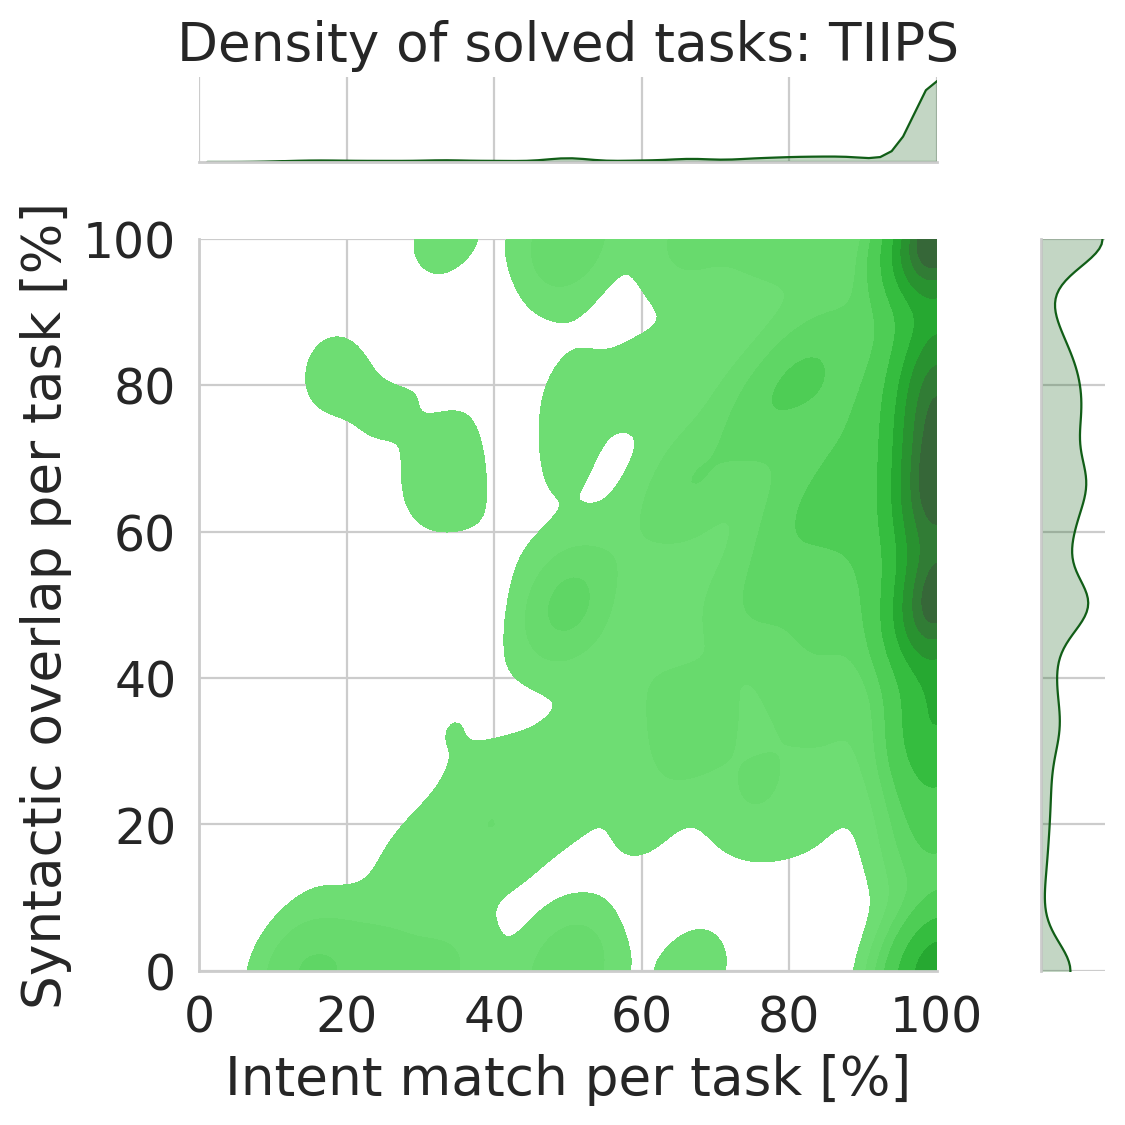

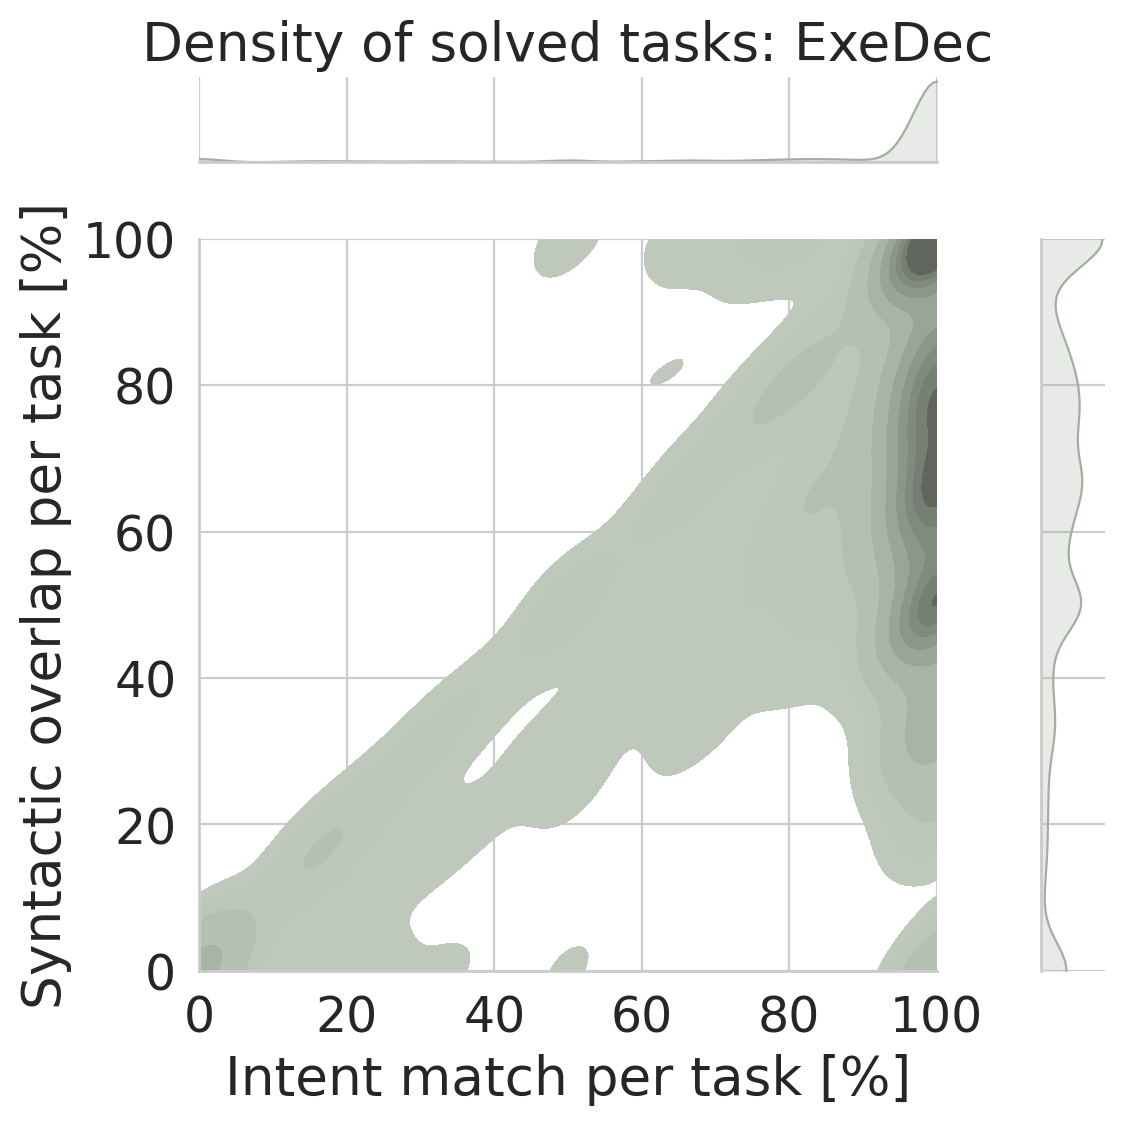

In [15]:
dataset = 'robustfill'
df = load_decomposition_data(dataset, "num_subgoal_success")
app = 'TIIPS'
filtered_tasks = df[df['Approach'] == app]
solved_tasks = filtered_tasks[filtered_tasks['Success'] == True]

g = sns.jointplot(solved_tasks, x="Correct Subgoals", y="Correct Subprograms", fill=True,  kind='kde', clip=((0, 100), (0, 100)), color=PALETTE[app])
g.ax_marg_x.set_title(f'Density of solved tasks: {app}')
plt.ylabel('Syntactic overlap per task [%]')
plt.xlabel('Intent match per task [%]')
plt.ylim((0, 100))
plt.xlim((0, 100))
plt.tight_layout()
g.fig.savefig(f"./mixed_results/plots/{context}/solved_tasks_average_density_{dataset}_{app}.svg", transparent=True)
tikzplotlib.save(f"./mixed_results/plots/{context}/solved_tasks_average_density_{dataset}_{app}.pgf", figure=g.fig)

app = 'ExeDec'
filtered_tasks = df[df['Approach'] == app]
solved_tasks = filtered_tasks[filtered_tasks['Success'] == True]

g = sns.jointplot(solved_tasks, x="Correct Subgoals", y="Correct Subprograms", fill=True,  kind='kde', clip=((0, 100), (0, 100)), color=PALETTE[app])
g.ax_marg_x.set_title(f'Density of solved tasks: {app}')
plt.ylabel('Syntactic overlap per task [%]')
plt.xlabel('Intent match per task [%]')
plt.ylim((0, 100))
plt.xlim((0, 100))
plt.tight_layout()
g.fig.savefig(f"./mixed_results/plots/{context}/solved_tasks_average_density_{dataset}_{app}.svg", transparent=True)
tikzplotlib.save(f"./mixed_results/plots/{context}/solved_tasks_average_density_{dataset}_{app}.pgf", figure=g.fig)


In [ ]:
dataset = 'deepcoder'
df = load_decomposition_data(dataset, "num_subgoal_success")
filtered_tasks = df[df['Approach'] == 'TIIPS']
solved_tasks = filtered_tasks[filtered_tasks['Success'] == True]

for e in solved_tasks['Experiment'].unique():
    g = sns.jointplot(solved_tasks[solved_tasks['Experiment'] == e], x="Correct Subgoals", y="Correct Subprograms", fill=True,  kind='kde', clip=((0, 100), (0, 100)), alpha=0.6)
    g.ax_marg_x.set_title(f'{EXP_LBL_MAP[e]}')
    plt.ylabel('Subprogram accuracy per task [%]')
    plt.xlabel('Subtask accuracy per task [%]')
    plt.ylim((0, 100))
    plt.xlim((0, 100))
    # g.fig.savefig(f"../results/plots/{context}/solved_tasks_{e}_density_{dataset}.svg")


# Baseline Effect

In [16]:
dataset = 'robustfill'

exp = {k: [np.nan] * 5 for k in EXPERIMENTS}
num_steps = {e: {"ExeDec": {"ExeDec": [], "Ground truth": []}, "Baseline": {"Baseline": [], "Ground truth": []}, "No-Subgoal Ablation": {"No-Subgoal Ablation": [], "Ground truth": []}, "TIIPS": {"TIIPS": [], "Ground truth": []}} for e in EXPERIMENTS}
sols = {"ExeDec": {e: {"Matches": [], "Mismatches": []} for e in EXPERIMENTS}, "Baseline": {e: {"Mismatches": [], "Matches": []} for e in EXPERIMENTS}, "TIIPS": {e: {"Mismatches": [], "Matches": []} for e in EXPERIMENTS}, "No-Subgoal Ablation": {e: {"Mismatches": [], "Matches": []} for e in EXPERIMENTS}}
for experiment in EXPERIMENTS:
    for j, seed in enumerate([10, 20, 30, 40, 50]):
        for prediction_type in ["separate", "separate-"]:
            pt = PT_MAPPING[prediction_type]
            pty = prediction_type[:-1] if prediction_type == 'separate-' else f'{prediction_type}'
            p = f"mixed_results/evaluation/{dataset}_e2e_predict_1/end_to_end_predict-{dataset}-run-e2e_predict_1-"
            try:
                with open(p + prediction_type + f'/tb/hparams-dataset_type={dataset},prediction_type={pty},experiment={experiment},beam_size=10,seed={seed}/results-{pty}.json') as f:
                    data = json.load(f)
            except FileNotFoundError:
                # print(p + prediction_type + f'/tb/hparams-dataset_type={dataset},prediction_type={pty},experiment={experiment},beam_size=10,seed={seed}/results-{pty}.json')
                continue
            
            exp[experiment][j] = len([ele for ele in data if ele["success"]]) / len(data) * 100 if len(data) == 1000 else np.nan
            num_steps[experiment][pt][pt] += [get_length(ele["solution"]) for ele in data if ele["success"]]
            num_steps[experiment][pt]["Ground truth"] += [ele["ground_truth_length"] for ele in data if ele["success"]]

            if prediction_type == "separate" or prediction_type == "sampling_updates":  # and len(data) == 1000:
                #sols[pt][experiment]["Matches"].append(sum(1 for s, g in zip([ele["solution"] for ele in data if ele["success"]], [ele["ground_truth"] for ele in data if ele["success"]]) if s == g))
                #sols[pt][experiment]["Mismatches"].append(sum(1 for s, g in zip([ele["solution"] for ele in data if ele["success"]], [ele["ground_truth"] for ele in data if ele["success"]]) if s != g))
                match_ratios = []
                for s, g in zip([ele["solution"] for ele in data if ele["success"]], [ele["ground_truth"] for ele in data if ele["success"]]):
                    s_parts = s.split(' | ')
                    g_parts = g.split(' | ')
                    match_ratios.append(sum(1 for sp, gp in zip(s_parts, g_parts) if sp == gp) / len(s_parts))
                sols[pt][experiment]['Matches'].append(match_ratios)

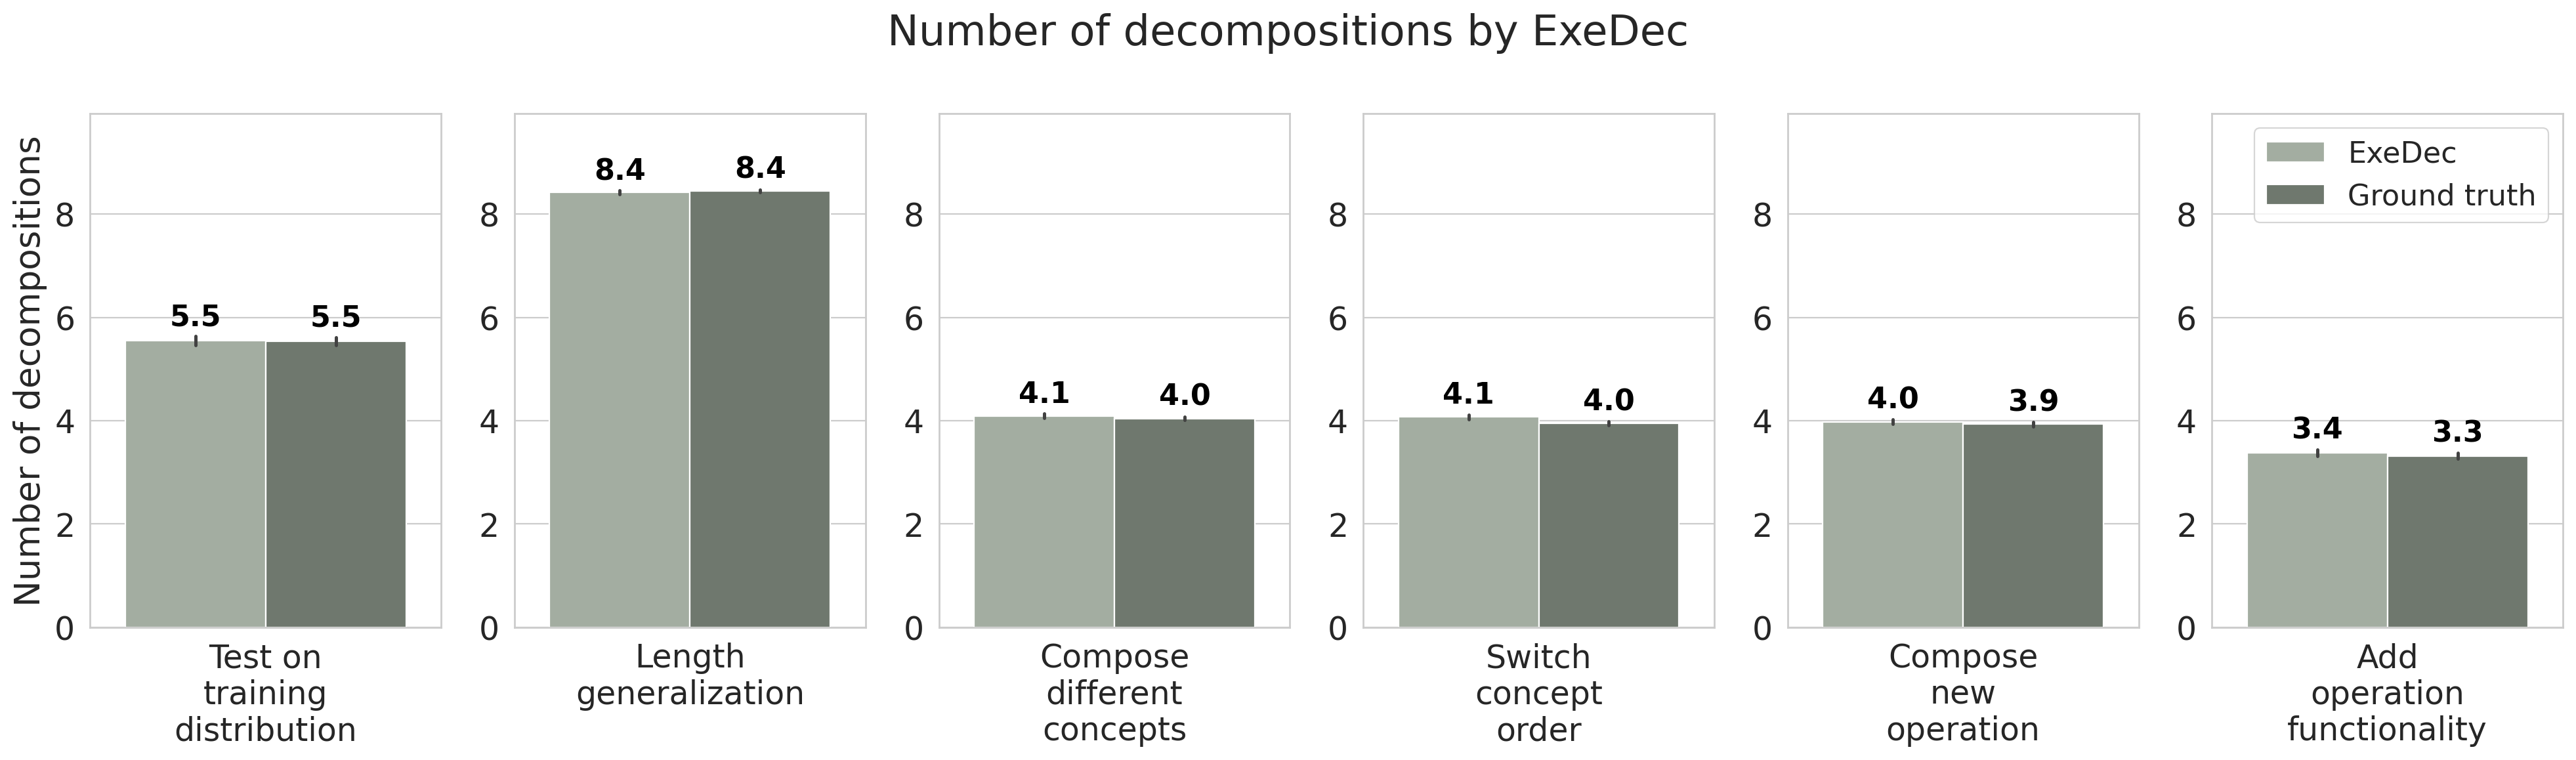

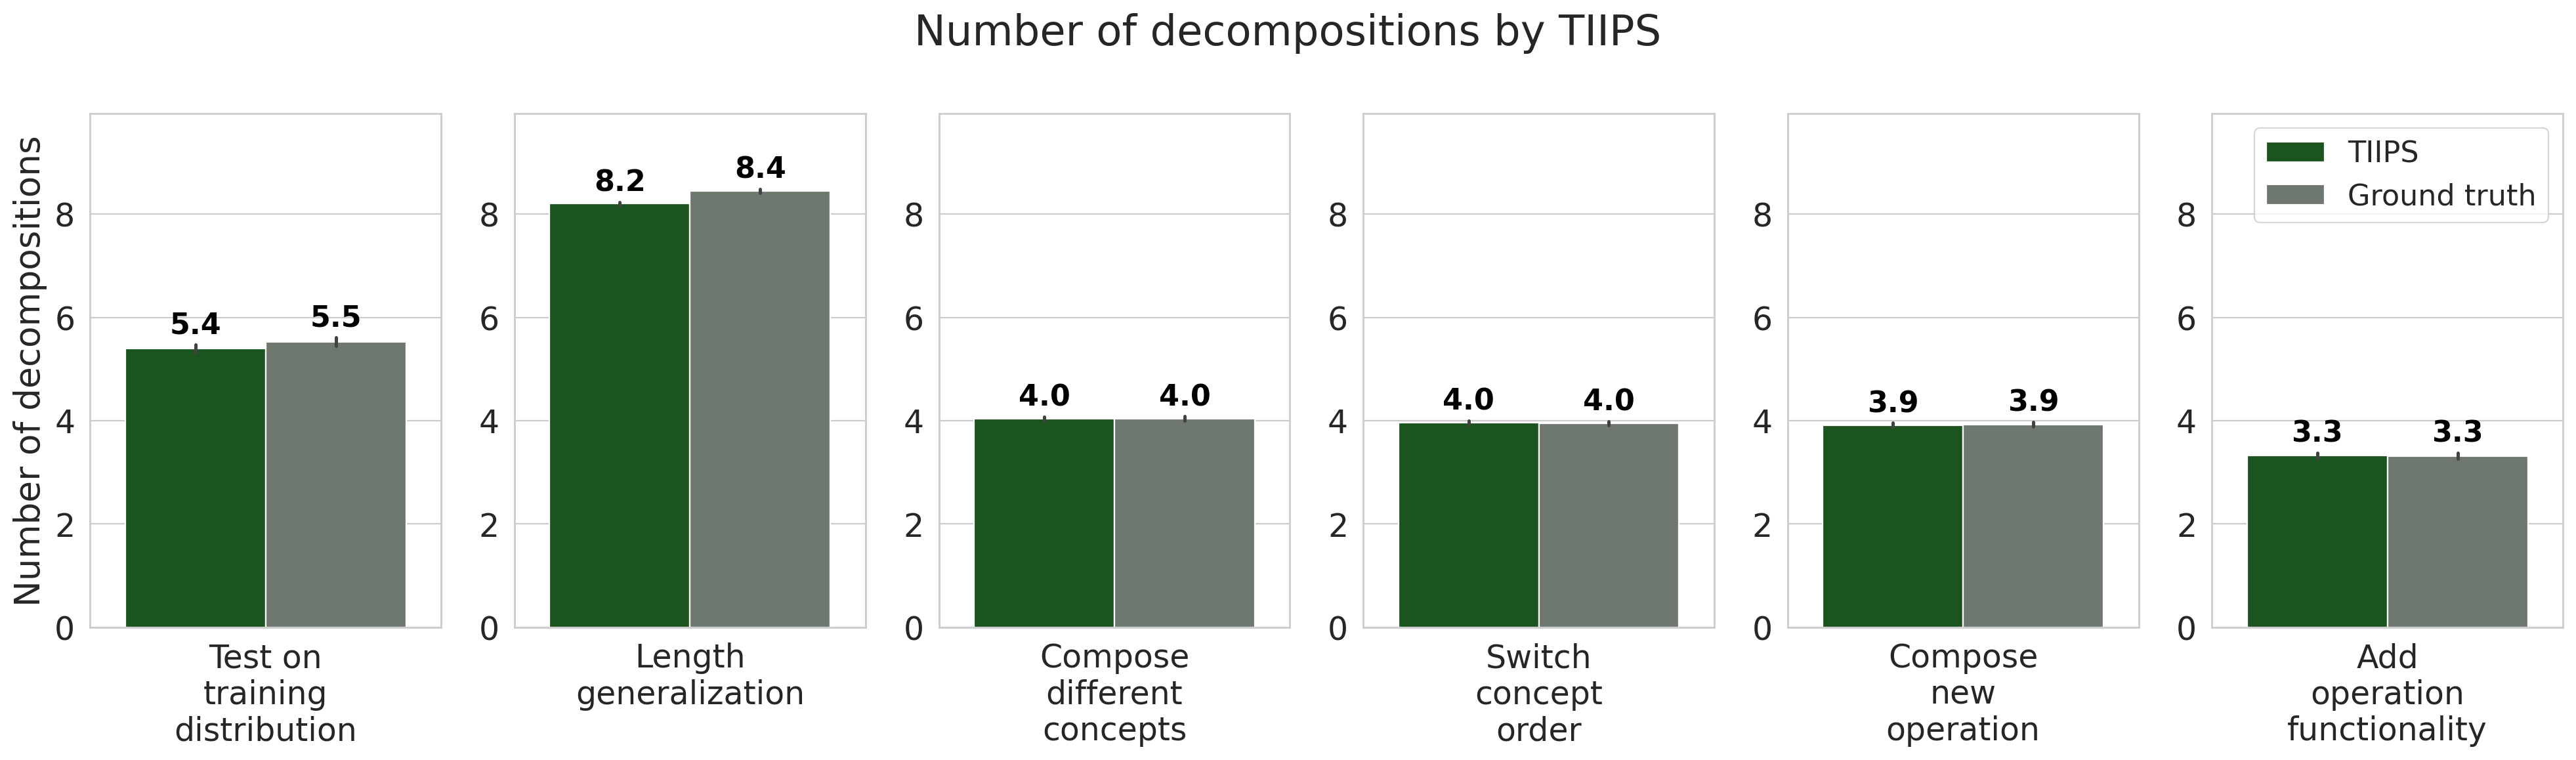

In [17]:
from scipy.stats import norm
rows = []
for pt, data in num_steps.items():
    for category, metrics in data.items():
        for key, values in metrics.items():
            for value in values:
                rows.append({"Approach": category, "Category": replace(EXP_LBL_MAP[pt], ' ', '\n', EXP_LBL_MAP[pt].count(' ')), "Legend": key, "Value": value})

# Convert the list of dictionaries to a pandas DataFrame
overall_df = pd.DataFrame(rows)
means = overall_df.groupby(['Approach', 'Category', 'Legend']).mean()
stddevs = overall_df.groupby(['Approach', 'Category', 'Legend']).std() / np.sqrt(overall_df.groupby(['Approach', 'Category', 'Legend']).count())

fig_width = 20
z_value = norm.ppf(0.5 + 0.95 / 2)

for m, app in enumerate(list(overall_df['Approach'].unique())):
    fig, axs = plt.subplots(1, 6, figsize=(fig_width, 6))# , gridspec_kw={'width_ratios': [fig_width / 6] * 6})
    df = overall_df[overall_df['Approach'] == app]
    for j, category in enumerate(list(df["Category"].unique())):
        axs[j] = sns.barplot(
            data=df[df["Category"] == category],
            x="Category",
            y="Value",
            hue="Legend",
            dodge=True,
            ax=axs[j],
            palette=PALETTE
        )
        if j == 0:
            axs[j].set_ylabel("Number of decompositions")
        else:
            axs[j].set_ylabel("")
        axs[j].set_xlabel("")
        axs[j].set_ylim((0, means.max()['Value'] + 1.5))
        if j != 5:
            axs[j].get_legend().remove()
        else:
            legend = axs[j].legend(loc="upper right", ncol=1, fontsize=16)
        # axs[j].tick_params('x', labelsize=10)
        for n, lgd in enumerate([app, 'Ground truth']):
            ci_upper = means.loc[(app, category, lgd), 'Value'] + z_value *  + stddevs.loc[(app, category, lgd), 'Value']
            axs[j].text(-4/fig_width if n == 0 else 4/fig_width, ci_upper + 0.1, f"{means.loc[(app, category, lgd), 'Value']:.1f}", 
                 ha='center', va='bottom', fontweight='bold', color='black', fontsize=16)
    for ax in axs:
        legend = ax.get_legend()
        if legend is not None and not hasattr(legend, "_ncol"):
            legend._ncol = legend._ncols if hasattr(legend, "_ncols") else 1
    fig.suptitle(f"Number of decompositions by {app}")
    fig.tight_layout()
    # fig.savefig(f"../exedec/results/plots/{context}/num_decompositions_barplot_{dataset}_{app}.svg", transparent=True)
    # tikzplotlib.save(f"../exedec/results/plots/{context}/num_decompositions_barplot_{dataset}_{app}.pgf", figure=fig)


### Step Length Determination
Ran MLITS with step sizes 2, 3, and 5 on 100 test samples.

In [ ]:
dataset = 'robustfill'
path = f"./mlits_results/evaluation/{dataset}_e2e_predict_1/end_to_end_predict-{dataset}-run-e2e_predict_1-"

accuracies = {"TIIPS": {sl: {} for sl in range(1, 21)}}
for prediction_type in ['mlits']:
    for sl in accuracies['TIIPS'].keys():
        exp = {k: [np.nan] * 5 for k in EXPERIMENTS}
        for experiment in EXPERIMENTS:
            for j, seed in enumerate([10, 20, 30, 40, 50]):
                s = f'-{sl}' if dataset == 'robustfill' else f'{sl}'
                try:
                    with open(path + prediction_type + s + f'/tb/hparams-dataset_type={dataset},prediction_type={prediction_type},experiment={experiment},beam_size=10,seed={seed}/results-{prediction_type}.json') as f:
                        data = json.load(f)
                except FileNotFoundError:
                    # print(path + prediction_type + f'/tb/hparams-dataset_type={ds},prediction_type={prediction_type},experiment={experiment},beam_size=10,seed={seed}/results-{prediction_type}.json')
                    continue
                exp[experiment][j] = len([ele for ele in data if ele["success"]]) / len(data) * 100 if len(data) == 100 else np.nan
        k = "TIIPS"
        accuracies[k][sl] = exp

# Transform data into a DataFrame suitable for seaborn plotting
df_list = []
for hue_key, subdict in accuracies.items():
    for sl, subsubdict in subdict.items():
        for category, values in subsubdict.items():
            for value in values:
                df_list.append({'Category': replace(EXP_LBL_MAP[category], ' ', '\n', EXP_LBL_MAP[category].count(' ')), 'Value': value, 'Type': hue_key, 'Step Length': sl})

df = pd.DataFrame(df_list)
df = df[df['Type'] != 'Sampling']
# df = df[df['Type'] != 'Baseline']
# df = df[df['Type'] == 'MLITS']
df = df.dropna()

# Filter out the 'None' category for overall average calculation
df_no_none = df[df['Category'] != 'Test on\ntraining\ndistribution']
# df_no_none = df_no_none[df_no_none['Category'] != 'Length\ngeneralization']
# df_no_none = df_no_none[df_no_none['Category'] != 'Switch\nConcept\nOrder']

# Calculate overall average across all categories except 'None' for each Type
overall_averages = df_no_none.groupby('Step Length')['Value'].mean().reset_index()
overall_averages['Category'] = 'Generalization\naverage'

# Append the overall average to the DataFrame
df = pd.concat([df, overall_averages], ignore_index=True)

# Calculate average accuracy for each Category-Type combination
averages = df.groupby(['Category', 'Step Length'])['Value'].mean().reset_index()
averages['std'] = df.groupby(['Category', 'Step Length'])['Value'].std().reset_index()['Value']
averages['std'] = averages['std'].fillna(0)

# Create the barplot
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(data=df, x='Category', y='Value', hue='Step Length', ax=ax, palette=sns.cubehelix_palette(start=2, rot=0, dark=0.2, light=0.6, reverse=True, as_cmap=True))

hue_types = df['Step Length'].unique()
num_hues = len(hue_types)
offsets = {hue_type: -0.3 + 0.6 / (num_hues - 1) * i for i, hue_type in enumerate(hue_types)}

# Add average accuracy annotations with dynamic offsets
for i, row in averages.iterrows():
    category = row['Category']
    avg_value = row['Value']
    std = row['std']
    # type_ = row['Type']
    sl_ = row['Step Length']
    x = list(df['Category'].unique()).index(category)  # x position for the category
    
    text = f"{avg_value:.1f}" # if avg_value < 10 else f" {avg_value:.1f}"
    
    plt.text(x + offsets[sl_], avg_value + 1.1 * std, f"{avg_value:.2g}", 
             ha='center', va='bottom', fontweight='bold', color='black', fontsize=7)


#plt.xticks(rotation=45, ha='right')
plt.title(f"Compositional generalization results on {dataset.title()}")
plt.xlabel("")
plt.ylabel("End-to-end test accuracy [%]")
fig.gca().set_ylim(0, 100)
plt.tight_layout()
ax.legend().set_title('')
# fig.savefig(f"../results/plots/{context}/accuracy_barplot_{dataset}.svg")

- ExeDec decomposes each task significantly more often than intended by the ground truth solution

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

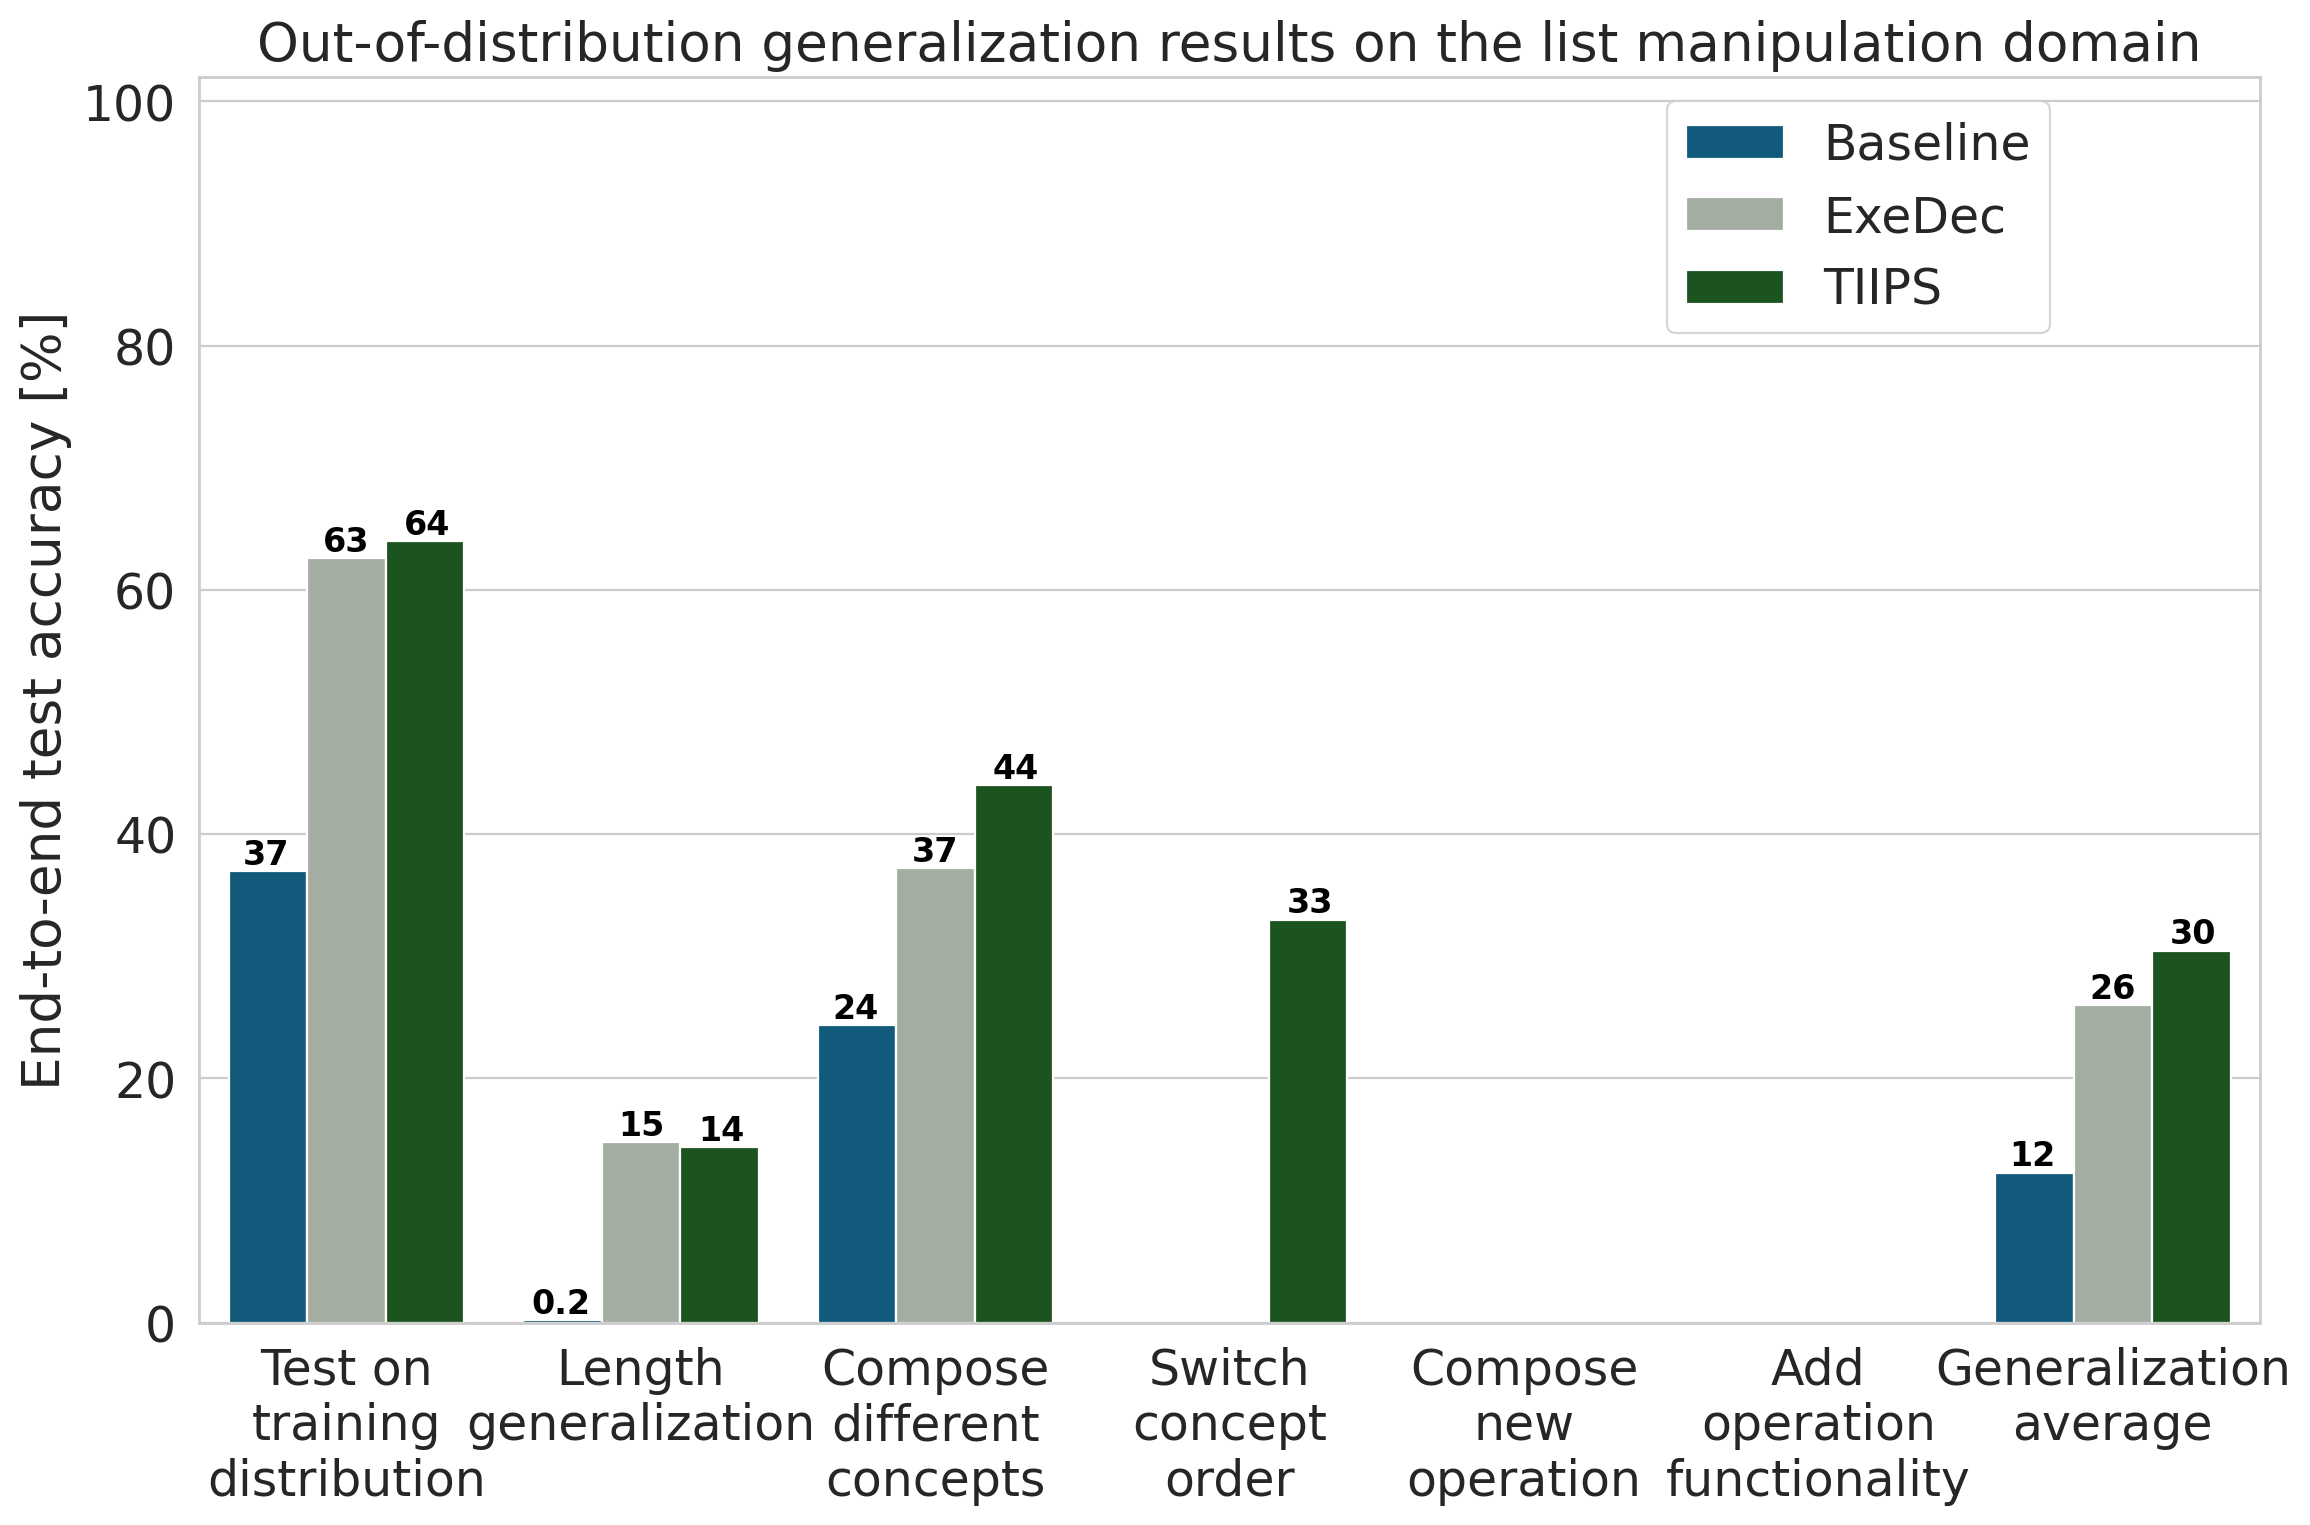

In [16]:
dataset = 'deepcoder'
stp_siz = '' # 20 if dataset == 'robustfill' else 5
accuracies = load_performance_data(dataset, threshold=500, step_size=stp_siz)
# Transform data into a DataFrame suitable for seaborn plotting
df_list = []
for hue_key, subdict in accuracies.items():
    for category, values in subdict.items():
        for value in values:
            df_list.append({'Category': replace(EXP_LBL_MAP[category], ' ', '\n', EXP_LBL_MAP[category].count(' ')), 'Value': value, 'Type': hue_key})

df = pd.DataFrame(df_list)
df = df[df['Type'] != 'No-Subgoal Ablation']

# Filter out the 'None' category for overall average calculation
df_no_none = df[df['Category'] != 'Test on\ntraining\ndistribution']
# df_no_none = df_no_none[df_no_none['Category'] != 'Length\ngeneralization']
# df_no_none = df_no_none[df_no_none['Category'] != 'Compose\nnew\noperation']

# Calculate overall average across all categories except 'None' for each Type
overall_averages = df_no_none.groupby('Type')['Value'].mean().reset_index()
overall_averages['Category'] = 'Generalization\naverage'

# Append the overall average to the DataFrame
df = pd.concat([df, overall_averages], ignore_index=True)

# Calculate average accuracy for each Category-Type combination
averages = df.groupby(['Category', 'Type'])['Value'].mean().reset_index()
averages['std'] = df.groupby(['Category', 'Type'])['Value'].std().reset_index()['Value']
averages['std'] = averages['std'].fillna(0)

# Create the barplot
fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.barplot(data=df, x='Category', y='Value', hue='Type', palette=PALETTE, ax=ax)
for line in ax.lines:
    line.set_color("gray")

hue_types = df['Type'].unique()
num_hues = len(hue_types)
offsets = {hue_type: -0.2725 + 0.545 / (num_hues - 1) * i for i, hue_type in enumerate(hue_types)}

# Add average accuracy annotations with dynamic offsets
for i, row in averages.iterrows():
    category = row['Category']
    avg_value = row['Value']
    std = row['std']
    type_ = row['Type']
    x = list(df['Category'].unique()).index(category)  # x position for the category
    
    text = f"{avg_value:.1f}" # if avg_value < 10 else f" {avg_value:.1f}"
    
    plt.text(x + offsets[type_], avg_value + 1.1 * std, f"{avg_value:.2g}", 
             ha='center', va='bottom', fontweight='bold', color='black', fontsize=12)


#plt.xticks(rotation=45, ha='right')
plt.title(f"Out-of-distribution generalization results on the {DATASET[dataset].lower()} domain")
plt.xlabel("")
plt.ylabel("End-to-end test accuracy [%]")
fig.gca().set_ylim(0, 102)
plt.tight_layout()
ax.legend().set_title('')
ax.legend(loc='upper right', bbox_to_anchor=(0.91, 1.0))
legend = ax.get_legend()
if legend is not None and not hasattr(legend, "_ncol"):
    legend._ncol = legend._ncols if hasattr(legend, "_ncols") else 1
fig.savefig(f"./mixed_results/plots/{context}/accuracy_barplot_{dataset}.svg", transparent=True)
tikzplotlib.save(f"./mixed_results/plots/{context}/accuracy_barplot_{dataset}.pgf", figure=fig)
# accuracies['TIIPS']

Spurious category patterns:
- Length generalization: None
- Compose different concepts:
  - Robustfill: A = substring operations, B = modifications + constants; No Compose
  - Deepcoder: A = first-order operation + Map, B = remaining higher-order operations
- Switch concept order:
  - Robustfill:  A = substring operations, B = modifications + constants; No Compose
  - Deepcoder: A = first-order operation + Map, B = remaining higher-order operations
- Compose new operation:
  - Robustfill: A = len 1 with Compose, B = len 2-6 without Compose
  - Deepcoder: A = len 1 with Scanl1, B = len 2-4 without Scanl1
- Add operation functionality:
  - Robustfill: training: Compose only without substring operations, testing: Compose only with substring operations
  - Deepcoder: training: scanl1 only with (-) and (min), testing scanl1 only with (+), (*), (max)

In [15]:
from tasks.deepcoder.deepcoder_dsl import FIRST_ORDER_AND_MAP, HIGHER_ORDER_NO_MAP, OPERATIONS_ONLY_SCAN, OPERATIONS_NO_SCAN, LAMBDAS_ONLY_MINUS_MIN , LAMBDAS_ONLY_PLUS_MUL_MAX
from tasks.robust_fill.dsl import ALL_SUBSTRINGS, ALL_MODIFICATIONS, ONLY_COMPOSE, CONST


def contains_both_cats(sol, catA, catB):
    containsA, containsB = False, False
    for opA in catA:
        if opA in sol:
            containsA = True
    for opB in catB:
        if opB in sol:
            containsB = True
    return containsA and containsB

def switches_concept_order(sol, catA, catB):
    subprograms = [ele for ele in sol.split(' | ') if 'INPUT' not in ele]
    first = False

    # Check whether the first operation is from category B
    for op in catB:
        if op in subprograms[0]:
            first = True
    if not first:
        return False
    
    for op in catA:
        if op in subprograms[-1]:
            return True
    return False

def composes_new_operation(sol, catA, catB, ds):
    # program len must be larger that 1 and contain the catB operation
    # if either is false, the concept shift was omitted
    subprograms = [ele for ele in sol.split(' | ') if 'INPUT' not in ele]
    if len(subprograms) < 2: 
        return False, False

    containsA, containsB = False, False

    # Check whether we use the catB & cat A operation at least once
    containsB = False
    if ds == 'robustfill':
        # Matches: any sequence of characters (non-whitespace, non-paren) followed by optional space and a ( ... )
        pattern = r'^(?!Const\b).*\([A-Za-z][^)]*\).*' # r'^(?!Const\b).*\(.*\).*'
        # Test all subprograms
        for sp in subprograms:
            if len(re.findall(pattern, sp)) > 0:
                containsB = True
            # In the ground truth test task solutions there exist tasks that are compose of only catB or only catA operations.
            # These tasks do not test the ood generalization abilities which is why we exclude them here.
            if len(re.findall(pattern, sp)) == 0:
                for op in catA:
                    if op in sp:
                        containsA = True

    elif ds == 'deepcoder':
        if 'Scanl1' in sol:
            containsB = True

        containsA = False
        for sp in subprograms:
            if not 'Scanl1' in sol:
                for op in catA:
                    if op in sp:
                        containsA = True
    return containsA, containsB

def adds_operation_functionality(solution, catA, catB, ds):
    if ds == 'deepcoder':
        for op in catA:
            if op in solution:
                return True
        return
        

def check_concept_shift_in_solution(solution, category, ds):

    if category == 'Compose\ndifferent\nconcepts':
        if ds == 'deepcoder':
            catA, catB = [ele.token for ele in FIRST_ORDER_AND_MAP], [ele.token for ele in HIGHER_ORDER_NO_MAP]
        elif ds == 'robustfill':
            catA, catB = [ele.token for ele in ALL_SUBSTRINGS], [ele.token for ele in ALL_MODIFICATIONS] + [ele.token for ele in CONST]
        return contains_both_cats(solution, catA, catB)

    elif category == 'Switch\nconcept\norder':
        if ds == 'deepcoder':
            catA, catB = [ele.token for ele in FIRST_ORDER_AND_MAP], [ele.token for ele in HIGHER_ORDER_NO_MAP]
        elif ds == 'robustfill':
            catA, catB = [ele.token for ele in ALL_SUBSTRINGS], [ele.token for ele in ALL_MODIFICATIONS] + [ele.token for ele in CONST]
        return switches_concept_order(solution, catA, catB)

    elif category == 'Compose\nnew\noperation':
        if ds == 'deepcoder':
            catA, catB = [ele.token for ele in OPERATIONS_ONLY_SCAN], [ele.token for ele in OPERATIONS_NO_SCAN]
        elif ds == 'robustfill':
            catA, catB = [ele.token for ele in ALL_SUBSTRINGS] + [ele.token for ele in ALL_MODIFICATIONS] + [ele.token for ele in CONST], None
        contA, contB = composes_new_operation(solution, catA, catB, ds)
        return contB 

    elif category == 'Add\noperation\nfunctionality':
        if ds == 'deepcoder':
            catA, catB = ['Scanl1 (+)', 'Scanl1 (*)', 'Scanl1 (max)'], None
        elif ds == 'robustfill':
            catA, catB = [ele.token for ele in ALL_SUBSTRINGS], None
        return adds_operation_functionality(solution, catA, catB, ds)
        
    return False

ds = 'deepcoder'
path = f"./mixed_results/evaluation/{ds}_e2e_predict_1//end_to_end_predict-{ds}-run-e2e_predict_1-"
accuracies = {"Baseline": [], "ExeDec": {},"No-Subgoal Ablation": {}, "TIIPS": {}}
threshold = 1000
for prediction_type in ["separate-", "separate", "sampling_updates"]:
    exp = {k: [np.nan] * 5 for k in EXPERIMENTS}
    for experiment in EXPERIMENTS:
        cat = EXP_LBL_MAP[experiment].replace(' ', '\n')
        for j, seed in enumerate(SEEDS): 
            pty = prediction_type[:-1] if prediction_type == 'separate-' else f'{prediction_type}'

            try:
                with open(path + prediction_type  + f'/tb/hparams-dataset_type={ds},prediction_type={pty},experiment={experiment},beam_size=10,seed={seed}/results-{pty}.json') as f:
                    data = json.load(f)
            except FileNotFoundError:
                # print(path + prediction_type + stp + f'/tb/hparams-dataset_type={ds},prediction_type={prediction_type},experiment={experiment},beam_size=10,seed={seed}/results-{prediction_type}.json')
                continue

            if len(data) == threshold:
                data = [ele for ele in data if ele['success']]
       
                used_concept_shift = [ele for ele in data if check_concept_shift_in_solution(ele['solution'], cat, ds)]
                acc = 0 if len(data) == 0 else len(used_concept_shift) / threshold * 100 # / len(data) * 100 
            else:
                acc = np.nan
            exp[experiment][j] = acc
    if prediction_type == "joint":
        k = "No-Subgoal Ablation"
    elif prediction_type == "sampling_updates":
        k = "Baseline"
    elif prediction_type == "ensemble":
        k = "Ensemble"
    elif prediction_type == "separate":
        k = "ExeDec"
    elif prediction_type == "separate-":
        k = "TIIPS"
    elif prediction_type == "baseline":
        k = "Synthesizer Model"
    else:
        raise ValueError(f"Unknown prediction type: {prediction_type}")
    accuracies[k] = exp


In [ ]:
df_list = []
for hue_key, subdict in accuracies.items():
    if not type(subdict) == dict:
        continue
    for category, values in subdict.items():
        for value in values:
            df_list.append({'Category': replace(EXP_LBL_MAP[category], ' ', '\n', EXP_LBL_MAP[category].count(' ')), 'Value': value, 'Type': hue_key})

df = pd.DataFrame(df_list)
print(df)

# Filter out the 'None' category for overall average calculation
df_no_none = df[df['Category'] != 'Test on\ntraining\ndistribution']
df_no_none = df_no_none[df_no_none['Category'] != 'Length\ngeneralization']

# Calculate overall average across all categories except 'None' for each Type
overall_averages = df_no_none.groupby('Type')['Value'].mean().reset_index()
overall_averages['Category'] = 'Generalization\naverage'

# Append the overall average to the DataFrame
df = pd.concat([df, overall_averages], ignore_index=True)

# Create the barplot
fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.barplot(data=df, x='Category', y='Value', hue='Type', palette=PALETTE, ax=ax)
for line in ax.lines:
    line.set_color("gray")

averages = df.groupby(['Category', 'Type'])['Value'].mean().reset_index()
averages['std'] = df.groupby(['Category', 'Type'])['Value'].std().reset_index()['Value']
averages['std'] = averages['std'].fillna(0)

hue_types = df['Type'].unique()
num_hues = len(hue_types)
offsets = {hue_type: -0.275 + 0.55 / (num_hues - 1) * i for i, hue_type in enumerate(hue_types)}

# Add average accuracy annotations with dynamic offsets
for i, row in averages.iterrows():
    category = row['Category']
    avg_value = row['Value']
    std = row['std']
    type_ = row['Type']
    x = list(df['Category'].unique()).index(category)  # x position for the category
    
    text = f"{avg_value:.1f}" # if avg_value < 10 else f" {avg_value:.1f}"
    
    plt.text(x + offsets[type_], avg_value + 1.1 * std, f"{avg_value:.2g}", 
             ha='center', va='bottom', fontweight='bold', color='black', fontsize=8)

In [57]:
dataset = 'deepcoder'

exp = {k: [np.nan] * 5 for k in EXPERIMENTS}
num_steps = {e: {"ExeDec": {"ExeDec": [], "Ground truth": []}, "Baseline": {"Baseline": [], "Ground truth": []}, "No-Subgoal Ablation": {"No-Subgoal Ablation": [], "Ground truth": []}, "TIIPS": {"TIIPS": [], "Ground truth": []}} for e in EXPERIMENTS}
sols = {"ExeDec": {e: {"Matches": [], "Mismatches": []} for e in EXPERIMENTS}, "Baseline": {e: {"Mismatches": [], "Matches": []} for e in EXPERIMENTS}, "TIIPS": {e: {"Mismatches": [], "Matches": []} for e in EXPERIMENTS}, "No-Subgoal Ablation": {e: {"Mismatches": [], "Matches": []} for e in EXPERIMENTS}}
for experiment in EXPERIMENTS:
    for j, seed in enumerate([10, 20, 30, 40, 50]):
        for prediction_type in ["separate", "separate-"]:
            pt = PT_MAPPING[prediction_type]
            pty = prediction_type[:-1] if prediction_type == 'separate-' else f'{prediction_type}'
            p = f"mixed_results/evaluation/{dataset}_e2e_predict_1/end_to_end_predict-{dataset}-run-e2e_predict_1-"
            try:
                with open(p + prediction_type + f'/tb/hparams-dataset_type={dataset},prediction_type={pty},experiment={experiment},beam_size=10,seed={seed}/results-{pty}.json') as f:
                    data = json.load(f)
            except FileNotFoundError:
                # print(p + prediction_type + f'/tb/hparams-dataset_type={dataset},prediction_type={pty},experiment={experiment},beam_size=10,seed={seed}/results-{pty}.json')
                continue
            
            exp[experiment][j] = len([ele for ele in data if ele["success"]]) / len(data) * 100 if len(data) == 1000 else np.nan
            num_steps[experiment][pt][pt] += [ele['num_steps'] if prediction_type == 'separate-' else get_length(ele['solution']) for ele in data if ele["success"]]
            num_steps[experiment][pt]["Ground truth"] += [ele["ground_truth_length"] for ele in data if ele["success"]]

            if prediction_type == "separate" or prediction_type == "sampling_updates":  # and len(data) == 1000:
                #sols[pt][experiment]["Matches"].append(sum(1 for s, g in zip([ele["solution"] for ele in data if ele["success"]], [ele["ground_truth"] for ele in data if ele["success"]]) if s == g))
                #sols[pt][experiment]["Mismatches"].append(sum(1 for s, g in zip([ele["solution"] for ele in data if ele["success"]], [ele["ground_truth"] for ele in data if ele["success"]]) if s != g))
                match_ratios = []
                for s, g in zip([ele["solution"] for ele in data if ele["success"]], [ele["ground_truth"] for ele in data if ele["success"]]):
                    s_parts = s.split(' | ')
                    g_parts = g.split(' | ')
                    match_ratios.append(sum(1 for sp, gp in zip(s_parts, g_parts) if sp == gp) / len(s_parts))
                sols[pt][experiment]['Matches'].append(match_ratios)


In [ ]:
from scipy.stats import norm
rows = []
for pt, data in num_steps.items():
    for category, metrics in data.items():
        for key, values in metrics.items():
            for value in values:
                rows.append({"Approach": category, "Category": replace(EXP_LBL_MAP[pt], ' ', '\n', EXP_LBL_MAP[pt].count(' ')), "Legend": key, "Value": value})

# Convert the list of dictionaries to a pandas DataFrame
overall_df = pd.DataFrame(rows)
overall_df = overall_df[overall_df['Legend'] != 'Ground truth']
means = overall_df.groupby(['Approach', 'Category', 'Legend']).mean()
stddevs = overall_df.groupby(['Approach', 'Category', 'Legend']).std() / np.sqrt(overall_df.groupby(['Approach', 'Category', 'Legend']).count())

fig_width = 20
z_value = norm.ppf(0.5 + 0.95 / 2)

#for m, app in enumerate(list(overall_df['Approach'].unique())):
fig, axs = plt.subplots(1, 6, figsize=(fig_width, 6))# , gridspec_kw={'width_ratios': [fig_width / 6] * 6})
df = overall_df# [overall_df['Approach'] == app]
for j, category in enumerate(list(df["Category"].unique())):
    axs[j] = sns.barplot(
        data=df[df["Category"] == category],
        x="Category",
        y="Value",
        hue="Legend",
        dodge=True,
        ax=axs[j],
        palette=PALETTE
    )
    if j == 0:
        axs[j].set_ylabel("Number of guidance calls")
    else:
        axs[j].set_ylabel("")
    axs[j].set_xlabel("")
    axs[j].set_ylim((0, means.max()['Value'] + 1.5))
    if j != 5:
        axs[j].get_legend().remove()
    else:
        legend = axs[j].legend(loc="upper right", ncol=1, fontsize=16)
    # axs[j].tick_params('x', labelsize=10)
    for n, app in enumerate(['ExeDec', 'TIIPS']):
        ci_upper = means.loc[(app, category, app), 'Value'] + z_value *  + stddevs.loc[(app, category, app), 'Value']
        axs[j].text(-4/fig_width if n == 0 else 4/fig_width, ci_upper + 0.1, f"{means.loc[(app, category, app), 'Value']:.1f}", 
                ha='center', va='bottom', fontweight='bold', color='black', fontsize=16)
for ax in axs:
    legend = ax.get_legend()
    if legend is not None and not hasattr(legend, "_ncol"):
        legend._ncol = legend._ncols if hasattr(legend, "_ncols") else 1
fig.suptitle(f"Number of calls to the transductive guidance model")
fig.tight_layout()
fig.savefig(f"./mixed_results/plots/{context}/transductive_calls_barplot_{dataset}.svg", transparent=True)
tikzplotlib.save(f"./mixed_results/plots/{context}/transdructive_calls_barplot_{dataset}.pgf", figure=fig)


# Decompositions are yet expedient (for most categories)
- ExeDec outperforms Baseline in all categories but Compose-New-Op
- Executing the Subprogram generated using the predicted Subtask generates the ground_truth subtask output -> proves their hypothesis that the Subgoal Model makes small errors but the Synthesizer Model compensates for those

In [99]:
dataset = 'deepcoder'
"""df = load_decomposition_data(dataset, "synth_subgoal_success")
solved_tasks = df[df['Success'] == True]
"""
df = load_decomposition_data(dataset, "num_subgoal_success")
solved_tasks = df[df['Success'] == True]# ['Correct Subprograms']

In [100]:
g = sns.jointplot(solved_tasks, x="Correct Subgoals", y="Correct Subprograms", fill=True,  kind='kde', clip=((0, 100), (0, 100)), alpha=0.6, palette=PALETTE, hue='Approach')
g.ax_marg_x.set_title(f'Density of solved tasks in {dataset.title()} domain')
for ax in g.fig.axes:
    legend = ax.get_legend()
    if legend:
        legend.set_title("")
        legend.set_bbox_to_anchor((0, 1)) 
        legend.set_loc("upper left") 

plt.ylabel('Subprogram accuracy [%]')
plt.xlabel('Overlap to ground truth decomposition [%]')
# plt.xlabel('Semantic Overlap to Ground Truth Decomposition per Task [%]')
plt.ylim((0, 100))
plt.xlim((0, 100))
# g.fig.savefig(f"../results/plots/{context}/density_Baseline_{dataset}.svg")

# The Synthesizer Model also learns expedient decompositions
- The Synthesizer Model also generates solutions that resemble the ground truth decomposition
- Additionally, other expedient decompositions are learned -> exploration

In [ ]:
tasks_solved_sampling = solved_tasks[solved_tasks['Approach'] == 'Baseline'][['Seed', 'Task']]
len(tasks_solved_sampling)
tasks_solved_exedec = solved_tasks[solved_tasks['Approach'] == 'ExeDec'][['Seed', 'Task']]

column = []
for i in solved_tasks.index:
    s = solved_tasks.loc[i, "Seed"]
    t = solved_tasks.loc[i, "Task"]
    a = solved_tasks.loc[i, "Approach"]
    
    if len(tasks_solved_sampling.loc[(tasks_solved_sampling['Seed'] == s) & (tasks_solved_sampling['Task'] == t)]) > 0 and len(tasks_solved_exedec.loc[(tasks_solved_exedec['Seed'] == s) & (tasks_solved_exedec['Task'] == t)]) > 0:
        k = f"Both - {a}"
    elif len(tasks_solved_sampling.loc[(tasks_solved_sampling['Seed'] == s) & (tasks_solved_sampling['Task'] == t)]) > 0:
        k = "Baseline"
    elif len(tasks_solved_exedec.loc[(tasks_solved_exedec['Seed'] == s) & (tasks_solved_exedec['Task'] == t)]) > 0:
        k = "ExeDec"
    else:
        raise ValueError()
    
    column.append(k)
solved_tasks.loc[:, 'Solved by'] = column

In [ ]:
da = solved_tasks.loc[((solved_tasks['Solved by'] != 'Both - ExeDec') & (solved_tasks['Solved by'] != 'Both - Baseline'))]
app = 'Baseline'
da = da[da['Approach'] == app]
#for e in da['Experiment'].unique():
d = da#[da['Experiment'] == e] 
g = sns.JointGrid(d, x="Correct Subgoals", y="Correct Subprograms", height=8, hue="Solved by")
j = normalize_marginals_kde(g, d, "Correct Subgoals", "Correct Subprograms", "Solved by", palette=PALETTE)
g.ax_marg_x.set_title(f'Density of exclusively solved tasks: {dataset.title()}')
g.ax_joint.set_ylabel('Subprogram accuracy [%]')
g.ax_joint.set_xlabel('Overlap to ground truth decomposition [%]')

# Add the legend to the joint plot
g.ax_joint.legend(handles=[HANDLES[2]], loc='upper left', title="")

g.fig.savefig(f"../exedec/results/plots/{context}/density_exclusive_{dataset}_{app}_average.svg", transparent=True)
tikzplotlib.save(f"../exedec/results/plots/{context}/density_exclusive_{dataset}_{app}_average.pgf", figure=fig)

- ExeDec solves most of the tasks that are not solved by Baseline by deploying the Decomposition strategy as intended by the ground truth 
- Baseline mostly solves tasks that are not solved by ExeDec by exploring new semantic & syntactic solutions
- ExeDec also does this to a lesser extend but we cannot exlude the impact of the Synthesizer Model here

In [ ]:
da = solved_tasks.loc[((solved_tasks['Solved by'] != 'ExeDec') & (solved_tasks['Solved by'] != 'Baseline'))]
#for e in da['Experiment'].unique():
d = da#[da['Experiment'] == e] 
g = sns.JointGrid(d, x="Correct Subgoals", y="Correct Subprograms", height=8, hue="Solved by")
j = normalize_marginals_kde(g, d, "Correct Subgoals", "Correct Subprograms", "Solved by", palette=PALETTE)
g.ax_marg_x.set_title(f'Density of non-exclusively solved tasks: {dataset.title()}')
g.ax_joint.set_ylabel('Subprogram accuracy [%]')
g.ax_joint.set_xlabel('Overlap to ground truth decomposition [%]')

# Add the legend to the joint plot
g.ax_joint.legend(handles=HANDLES, loc='upper left', title="")
# g.fig.savefig(f"../results/plots/{context}/density_nonexclusive_{dataset}.svg")

In [15]:
ds = dataset = 'robustfill'
results = {"ExeDec": {s: {k: [] * 5 for k in EXPERIMENTS} for s in SEEDS}, "Baseline": {s: {k: [] * 5 for k in EXPERIMENTS} for s in SEEDS}, "No-Subgoal Ablation": {s: {k: [] * 5 for k in EXPERIMENTS} for s in SEEDS}}
for prediction_type in results.keys():
    pt = prediction_type
    for experiment in EXPERIMENTS:
        
        for j, seed in enumerate(SEEDS):
            if pt == "ExeDec":
                sd = "subgoal_success"
                prediction_type = 'separate'
            elif pt == "Baseline":
                sd = "subgoal_success"
                prediction_type = f'sampling_updates'
            elif pt == "No-Subgoal Ablation":
                sd = ""
                prediction_type = 'joint'
            else:
                raise ValueError(f"No such type as {prediction_type}")
            if SYNTH_MODEL == "baseline_model" and prediction_type in ['separate', 'joint']:
                if dataset == "deepcoder":
                    pred_dir = f'{prediction_type}'
                else:
                    pred_dir = f'{prediction_type}-synthesizer_model'
            else:
                if prediction_type in ['separate', 'joint']:
                    pred_dir = f'{prediction_type}-synthesizer_model'
                else:
                    pred_dir = f'{prediction_type}-{SYNTH_MODEL}'
            path = f"../exedec/exedec_results/evaluation/{ds}_e2e_predict_1/{sd}/end_to_end_predict-{ds}-run-e2e_predict_1-"
            try:
                with open(path + pred_dir + f'/tb/hparams-dataset_type={dataset},prediction_type={prediction_type},experiment={experiment},beam_size=10,seed={seed}/results-{prediction_type}.json') as f:
                    data = json.load(f)
            except FileNotFoundError:
                print(pt)
                continue
            for task in data:
                if task['success']:
                    results[PT_MAPPING[prediction_type]][seed][experiment].append(task['test_example_index'])
df_list = []
for pred_type, subdict in results.items():
    for s, subsubdict in subdict.items():
        for exp, values in subsubdict.items():
            for value in values:
                df_list.append({'Approach': pred_type, 'Task': value, 'Category': exp, 'Seed': s})

df = pd.DataFrame(df_list)

In [ ]:
sees, cats, apps, vals = [], [], [], []
l = len(data)
for s in SEEDS:
    df_seed = df[df['Seed'] == s]
    for cat in df_seed['Category'].unique():
        df_cat = df_seed[df_seed['Category'] == cat]

        exe_solved = df_cat[df_cat['Approach'] == "No-Subgoal Ablation"]['Task'].values
        sau_solved = df_cat[df_cat['Approach'] == "Baseline"]['Task'].values
        both = [t for t in exe_solved if t in sau_solved]
        only_exe = [t for t in exe_solved if t not in sau_solved]
        only_sau = [t for t in sau_solved if t not in exe_solved]

        sees += [s] * 3
        cats += [replace(EXP_LBL_MAP[cat], ' ', '\n', EXP_LBL_MAP[cat].count(' '))] * 3
        apps += ["Both", "No-Subgoal Ablation Only", "Baseline Only"]
        vals += [len(both) / l * 100, len(only_exe) / l * 100, len(only_sau) / l * 100]
task_df = pd.DataFrame({"Seed": sees, "Category": cats, "Approach": apps, "Value": vals})

pal = sns.color_palette()

fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
sns.barplot(data=task_df, x='Category', y='Value', hue='Approach', ax=ax, palette=PALETTE)
plt.title("Relative number of tasks solved by either or both approaches")
ax.set_ylabel("End-to-end test accuracy [%]")
ax.set_xlabel("")
ax.legend().set_title('')
# fig.savefig(f"../results/plots/{context}/barplot_exclusively_solved_{dataset}.svg")

- Sampling also solves a substantial part of tasks that are also solved by ExeDec with alternative solutions -> use sampling for exploration, acquiring new decomposition patterns that are not included in the training of the Subgoal Model
- To properly assess the impact of the Subgoal Model one would need to train the Synthesizer Model on single step tasks, regardless of the OOD category. Only the decomposition model should be trained for each category separately.
- After doing this, performing this analysis again would give more insights in how effective the Subgoal Model is and in how effective sampling is in generative alternative solutions
  - This is done in Length Generalization, where ExeDec significantly outperforms the Sampling the Synthesizer Model, but the No-Subgoal Ablation still outperforms ExeDec here
  - Training Synthesizer Model on subtasks but provide the final output sample likely outperforms ExeDec & the no-subgoal ablation when sampling
## OOD operation usage in task solutions

In [ ]:
# Define the OOD operations based on the test task
ood_operations = {
    "COMPOSE_DIFFERENT_CONCEPTS": {"Scanl1", "Map"},
    "SWITCH_CONCEPT_ORDER": {"Scanl1", "Map"},
    "COMPOSE_NEW_OP": {"Scanl1"},
    "ADD_OP_FUNCTIONALITY": {"Scanl1 (max)", "Scanl1 (*)", "Scanl1 (+)"}
}

dataset = 'deepcoder'
df = load_decomposition_data(dataset, "synth_subgoal_success", task_index=False)
solved_tasks = df[df['Success'] == True]
solved_tasks_only_ood = solved_tasks[solved_tasks['Experiment'] != 'NONE']
solved_tasks_only_ood = solved_tasks_only_ood[solved_tasks_only_ood['Experiment'] != 'LENGTH_GENERALIZATION']

contains_ood = []
lbls = []
for i in range(len(solved_tasks_only_ood)):
    contains_ood.append(contains_ood_operation(solved_tasks_only_ood.iloc[i]['Task']['ground_truth'], solved_tasks_only_ood.iloc[i]['Task']['solution'], ood_operations[solved_tasks_only_ood.iloc[i]['Experiment']]))
    lbls.append(replace(EXP_LBL_MAP[solved_tasks_only_ood.iloc[i]['Experiment']], ' ', '\n', EXP_LBL_MAP[solved_tasks_only_ood.iloc[i]['Experiment']].count(' ')))
solved_tasks_only_ood['Contains OOD Operation'] = contains_ood
solved_tasks_only_ood['Experiment'] = lbls

grouped = solved_tasks_only_ood.groupby(["Experiment", "Contains OOD Operation"]).size()
normalized = grouped.groupby(level=0).apply(lambda x: 100 * x / x.sum())

percentage_data = normalized.reset_index(name="Percentage", allow_duplicates=True)
percentage_data = percentage_data.loc[:,~percentage_data.columns.duplicated()].copy()


In [ ]:
sns.barplot(
    data=percentage_data,
    hue="Contains OOD Operation",
    y="Percentage",
    x="Experiment"
)